In this notebook, we will deploy the Shen et al (2017) model to predict PM2.5 for model simulations, and then com

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import cartopy.crs as ccrs
import cmocean

import logging
logging.basicConfig(level=logging.WARNING)

import xarray as xr
import pandas as pd
import numpy as np

import air_quality as aq
from air_quality.plot import usa_states_ax
from air_quality.models.shen2017 import Shen2017Model

from tqdm import tqdm, tqdm_notebook
tqdm_notebook()

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
/Users/daniel/anaconda/lib/python3.5/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


0it [00:00, ?it/s]

# Validation - Present Day Obs

For validation purposes, let's fit the model to present day observations. We can then do some quick statistics to see how well it performs.

In [3]:
grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dilon, dilat = 6, 4

data = xr.open_dataset("../data/processed/lu_2017/obs.usa_subset.nc")
# Mask out cells where we have no PRECIP data
mask = np.isnan(data.PRECIP.isel(time=0)).rename("CONUS_MASK")

month = 7
obs_model = Shen2017Model(
    data, month=month, mask=mask,
    verbose=True, n_predictors=3, cross_validate=False
)

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


Fit the model. This should take quite some time, even though we only fit for one month at a time.

In [4]:
import pickle

# obs_model.fit_parallel(4)
obs_model = pickle.load(open("../data/processed/lu_2017/obs.7.no_cv.p", 'rb'))

Cache this model to disk.

In [4]:
obs_model.to_pickle("../data/processed/lu_2017/obs.7.no_cv.p")

Now we can re-predict (in-sample) PM2.5 using the statistical model. This is somewhat "unfair" sine this data was also used to train the model, but it at least gets us at a rough start at what should be going on.

In [5]:
ref = data.copy().sel(time=data['time.month'] == month)
_to_model = obs_model.transform(ref)
predicted = obs_model.predict(_to_model)
predicted = obs_model.untransform(predicted)

Iterate over grid cell models: 100%|██████████| 288/288 [00:06<00:00, 47.58it/s]


## Plots

The most straightforward plot is to compare the predicted and observed PM2.5 for a given year.

In [6]:
from air_quality.plot import usa_states_ax, STATE_PROJ

def plot_predicted_vs_actual(predicted, ref, geo=True, cmap_kws={}):
    
    subplot_kw = {}
    if geo:
        subplot_kw['projection'] = STATE_PROJ
        
    fig, axs = plt.subplots(1, 3, figsize=(18., 4),
                            subplot_kw=subplot_kw)
    ax1, ax2, ax3 = axs.ravel()
    default_cmap_kws = dict(
        vmin=0, vmax=30, cmap=cmocean.cm.deep,
    )
    default_cmap_kws.update(cmap_kws)
    
    transform = ccrs.PlateCarree() if geo else None

    ts = "{}/{:02d}/01".format(2006, month)
    predicted.plot.imshow(ax=ax1, transform=transform, **default_cmap_kws)
    ax1.set_title('Modeled')
    ref.plot.imshow(ax=ax2, transform=transform, **default_cmap_kws)
    ax2.set_title('Observed')

    (100*(predicted - ref)/ref).plot.imshow(ax=ax3,
        vmin=-100, vmax=100, cmap='bwr', center=0, transform=transform,
        cbar_kwargs=dict(label="")
    )
    ax3.set_title("Relative Error (%)")
    if geo:
        for ax in axs:
            ax = usa_states_ax(ax=ax, facecolor='None')

    plt.tight_layout()
    return fig, axs

/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:352: RuntimeWarning: invalid value encountered in greater
  x_extent) > FRACTIONAL_OFFSET_THRESHOLD
/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:364: RuntimeWarning: invalid value encountered in greater
  y_extent) > FRACTIONAL_OFFSET_THRESHOLD


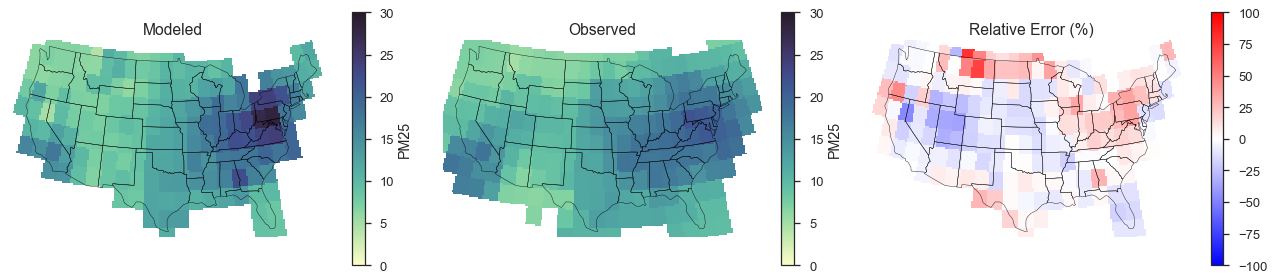

In [7]:
ts = "{}/{:02d}/01".format(2005, month)
pred_plot = predicted.sel(time=ts)['PM25']
ref_plot = ref.sel(time=ts)['PM25']

fig, axs = plot_predicted_vs_actual(pred_plot, ref_plot)

A second useful comparison is one-one prediction plots at specified location. Here we show just a few.

38.3 -85.76
32.5 -82.5
42 -71.0


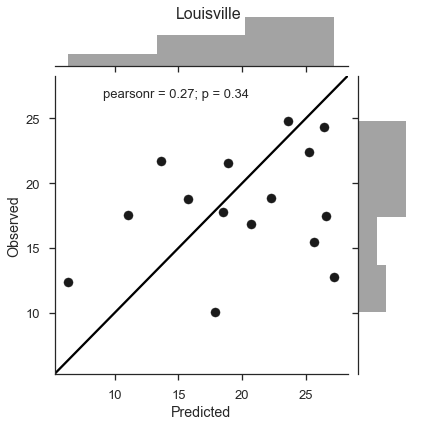

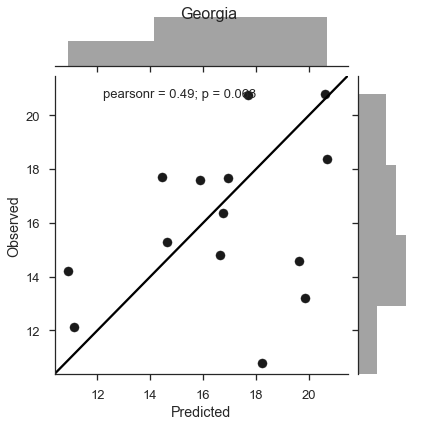

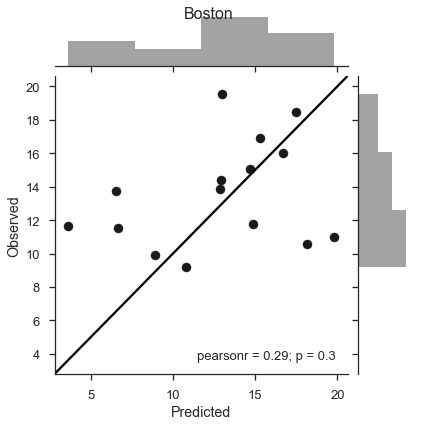

In [11]:
from air_quality.models.shen2017 import sites
import seaborn as sns

def plot_sites(predicted, ref):

    figs = {}
    
    for _, site in sites.items():
        fig = plt.figure()
        print(site.lat, site.lon)

        y_df = (
            ref
            .copy()
            .sel(lat=site.lat, lon=site.lon, method='nearest')
            .to_dataframe()
        )
        x_df = predicted.sel(lat=site.lat, lon=site.lon, method='nearest').to_dataframe()
        try:
            g = sns.jointplot(x_df['PM25'], y_df['PM25'], kind='scatter', color='0.1')
        except:
            continue
        ylo, yhi = g.ax_joint.get_ylim()
        xlo, xhi = g.ax_joint.get_xlim()
        lo = min([xlo, yhi])
        lo = max([lo, 0.])
        hi = max([xhi, yhi])
        g.ax_joint.plot([lo, hi], [lo, hi], color='k')
        g.ax_joint.set_xlim(lo, hi)
        g.ax_joint.set_ylim(lo, hi)
        g.set_axis_labels('Predicted', 'Observed')
        g.fig.suptitle(site.name, fontsize=16)
        
        figs[site.name] = fig
    
    return figs

figs = plot_sites(predicted, ref)

# Predicted w/ CESM/CAM-Chem

Similarly, we will fit a model for CESM/CAM-Chem using a present-day simulation. We can then compare forecast PM2.5 from the observations-fitted model and the model-fitted model to what CESM/CAM-Chem actually predicts.

In [8]:
grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dilon, dilat = 6, 4

data_model = xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
data_model = data_model.sel(pol='REF', dec='1980-2010', ic=3)

We need to interpolate the model data to the observational grid; CESM/CAM-Chem has a latitudinal resolution of ~1.9 degrees instead of 2.5, so we have a few more grid cells. We can do this with pyresample, following [this example](http://earthpy.org/interpolation_between_grids_with_pyresample.html).

In [9]:
import pyresample

lon_obs2d, lat_obs2d = np.meshgrid(data.lon.values, data.lat.values)
obs_def = pyresample.geometry.SwathDefinition(lons=lon_obs2d, lats=lat_obs2d)

lon_mod2d, lat_mod2d = np.meshgrid(data_model.lon.values, data_model.lat.values)
mod_def = pyresample.geometry.SwathDefinition(lons=lon_mod2d, lats=lat_mod2d)

def model_to_obs_grid(model_data, obs_def=obs_def, mod_def=mod_def):
    """ Resample data from a model to the obs grid. """
    data_model_rs = xr.Dataset(coords={'lon': data.lon, 
                                       'lat': data.lat, 
                                       'time': data_model.time})

    resample_to_obs = lambda data2d: pyresample.kd_tree.resample_nearest(
        mod_def, data2d, obs_def, radius_of_influence=500000, fill_value=None
    )

    for field in model_data.data_vars:
        print(field)
        da = model_data[field]
        da_rs = np.asarray([
            resample_to_obs(da.sel(time=t).values) for t in da.time
        ])
        data_model_rs[field] = (['time', 'lat', 'lon'], da_rs)
        
    return data_model_rs

data_model_rs = model_to_obs_grid(data_model)

PM25
TEMP
PRECIP
RH
U
V


As a sanity check, we can compare the dataset before and after resampling.

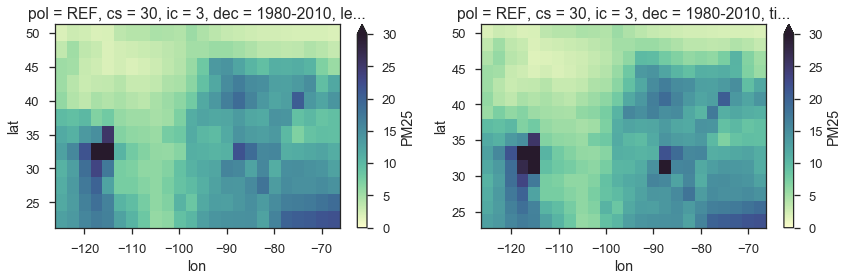

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
cmap_kws = dict(
    vmin=0, vmax=30, cmap=cmocean.cm.deep
)
t = 301
data_model_rs['PM25'].isel(time=t).plot.imshow(ax=ax1, **cmap_kws)
data_model['PM25'].isel(time=t).plot.imshow(ax=ax2, **cmap_kws)
plt.tight_layout()

*Now*, we're all ready to fit a new model to this data.

In [11]:
model_model = Shen2017Model(
    data_model_rs, month=month, mask=mask,
    verbose=True, n_predictors=3, cross_validate=False
)

In [12]:
import pickle

# model_model.fit_parallel(4)
model_model = pickle.load(
    open("../data/processed/lu_2017/fgm.REF.ic3.1980-2010.7.regrid.no_cv.p", 'rb')
)

In [82]:
model.to_pickle("../data/processed/lu_2017/fgm.REF.ic3.1980-2010.7.regrid.no_cv.p")

In [13]:
ref_model_rs = data_model_rs.copy().sel(time=data_model_rs['time.month'] == month)
_to_model = model_model.transform(ref_model_rs)
predicted = model_model.predict(_to_model)
predicted = model_model.untransform(predicted)

# Mask out pathological predictions
predicted = predicted.where(predicted > 0)

Iterate over grid cell models: 100%|██████████| 288/288 [00:12<00:00, 22.16it/s]
/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


## Comparison Plots

First, we can repeat the same two sets of plots as before to get a sense of how good or bad the model does at fitting the CESM data.

/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:352: RuntimeWarning: invalid value encountered in greater
  x_extent) > FRACTIONAL_OFFSET_THRESHOLD
/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:364: RuntimeWarning: invalid value encountered in greater
  y_extent) > FRACTIONAL_OFFSET_THRESHOLD


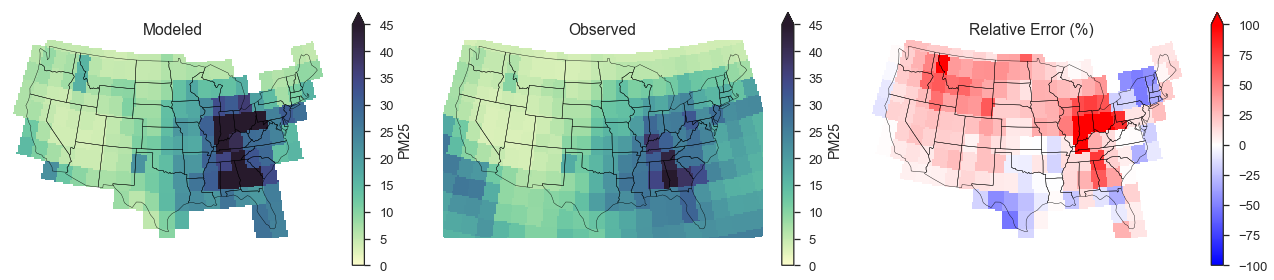

In [14]:
ts = "{}/{:02d}/01".format(2003, month)
pred_plot = predicted.sel(time=ts)['PM25']
ref_plot = ref_model_rs.sel(time=ts)['PM25']

fig, axs = plot_predicted_vs_actual(pred_plot, ref_plot, cmap_kws=dict(vmax=45))

38.3 -85.76
32.5 -82.5
42 -71.0


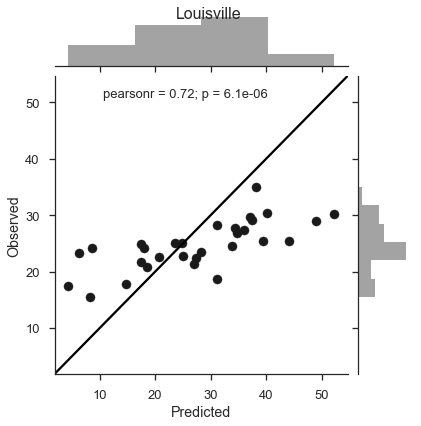

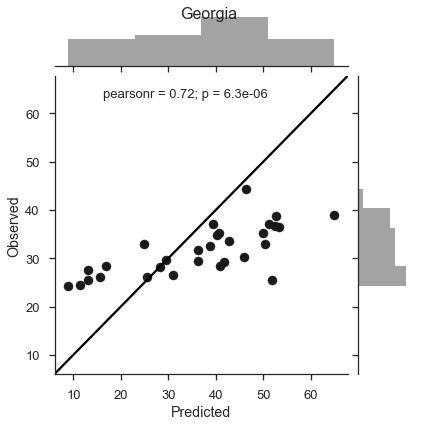

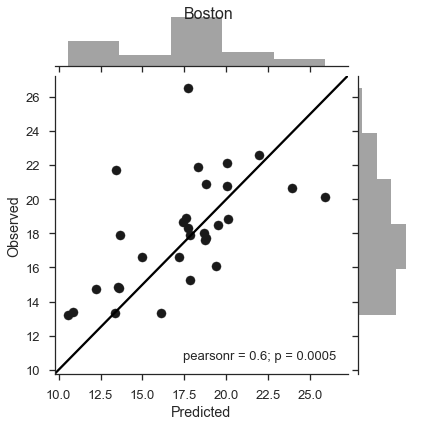

In [19]:
figs = plot_sites(predicted, ref_model_rs)

## Future PM2.5 Predictions

How does the statistical model prediction of future PM2.5 change compare to the actual prognostic model's?

In [16]:
data_fgm = xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
data_future = data_fgm.sel(pol='REF', dec='2035-2065', ic=1)
data_present = data_fgm.sel(pol='REF', dec='1980-2010', ic=1)

data_future_rs = model_to_obs_grid(data_future)
data_present_rs = model_to_obs_grid(data_present)

PM25
TEMP
PRECIP
RH
U
V
PM25
TEMP
PRECIP
RH
U
V


Using our statistical models, let's try to predict the future PM2.5. There's an important idiosyncrasy here, though: how, exactly, do we transform our meteorology data to the statistical distributions used to fit the predictive model? 

1. Lu Shen claims that he simply scaled the data using the un-modified, original dataset. But that's not what he did in his code - he re-normalized each meteorology set deparately.

2. Here, I'm going to try that same way. But I have also iterated with natively rescaling the data to the model being used and that produced really, really messy results. The best results were taken by using the "transform" cached with the statistical model fit to CESM/CAM-Chem for *both* obs and model.

In [17]:
from air_quality.models.shen2017 import _normalize

_to_model_future = data_future_rs.sel(time=data_future_rs['time.month'] == month).copy()
_to_model_present = data_present_rs.sel(time=data_present_rs['time.month'] == month).copy()


obs_predicted_future = obs_model.predict(
    model_model.transform(_to_model_future)
)
obs_predicted_future = model_model.untransform(obs_predicted_future)
obs_predicted_present = obs_model.predict(
    model_model.transform(_to_model_present)
)
obs_predicted_present = model_model.untransform(obs_predicted_present)


model_predicted_future = model_model.predict(
    model_model.transform(_to_model_future)
)
model_predicted_future = model_model.untransform(model_predicted_future)
model_predicted_present = model_model.predict(
    model_model.transform(_to_model_present)
)
model_predicted_present = model_model.untransform(model_predicted_present)


# Mask out pathological predictions
obs_predicted_future = obs_predicted_future.where(obs_predicted_future > 0)
model_predicted_future = model_predicted_future.where(model_predicted_future > 0)
obs_predicted_present = obs_predicted_present.where(obs_predicted_present > 0)
model_predicted_present = model_predicted_present.where(model_predicted_present > 0)

Iterate over grid cell models: 100%|██████████| 288/288 [00:13<00:00, 22.02it/s]
/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive



### Postage-stamps

Future mean PM2.5 predicted by the statistical model fitted to CESM/CAM-Chem and CESM/CAM-Chem's actual projections.

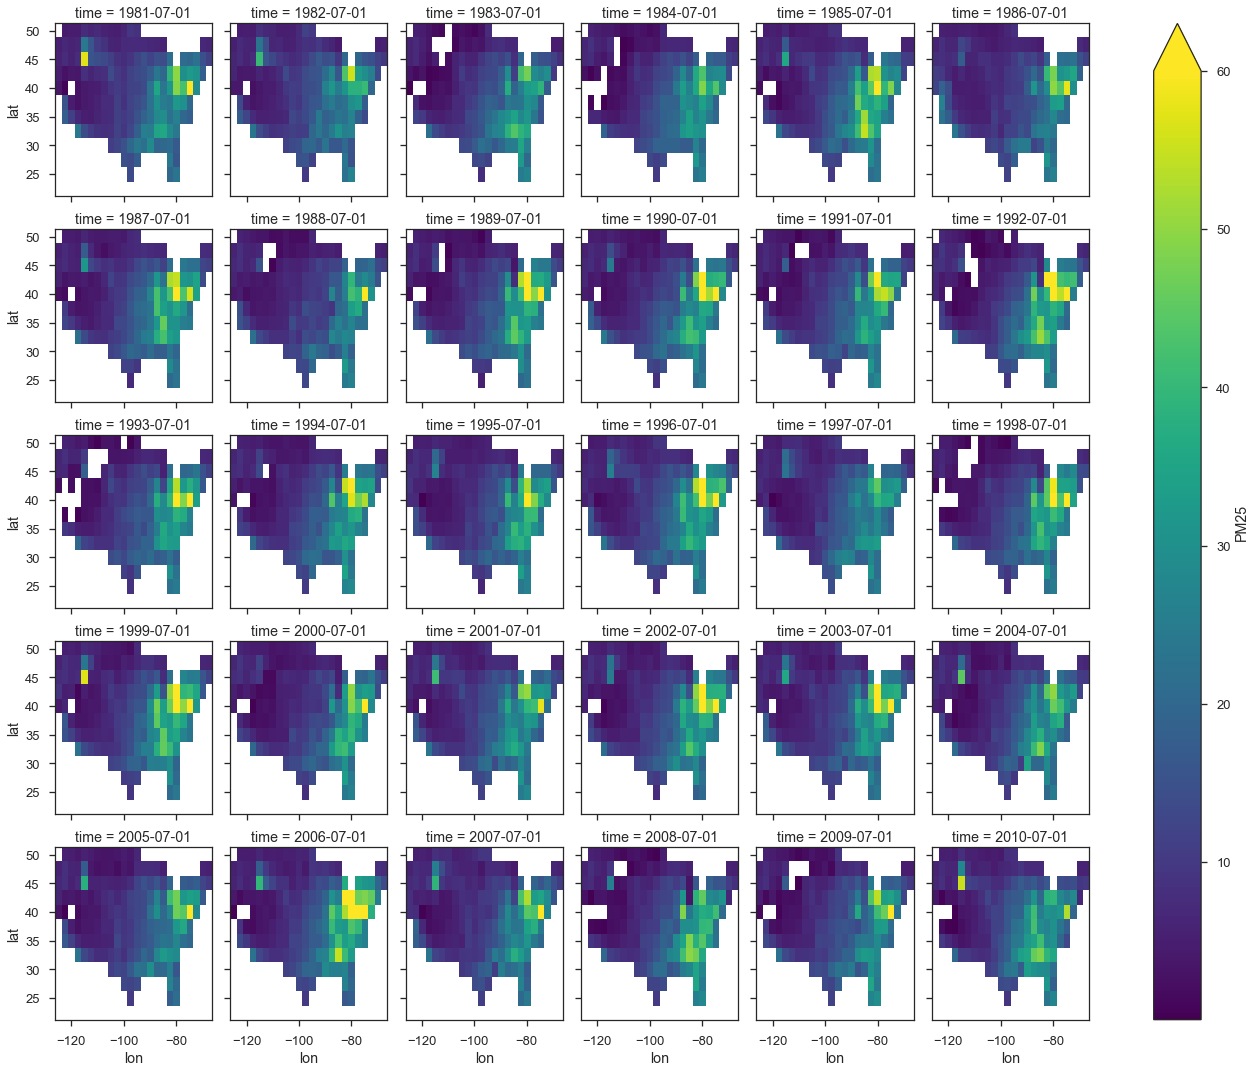

In [137]:
obs_predicted_future['PM25'].plot.imshow(col='time',col_wrap=6, vmax=60)

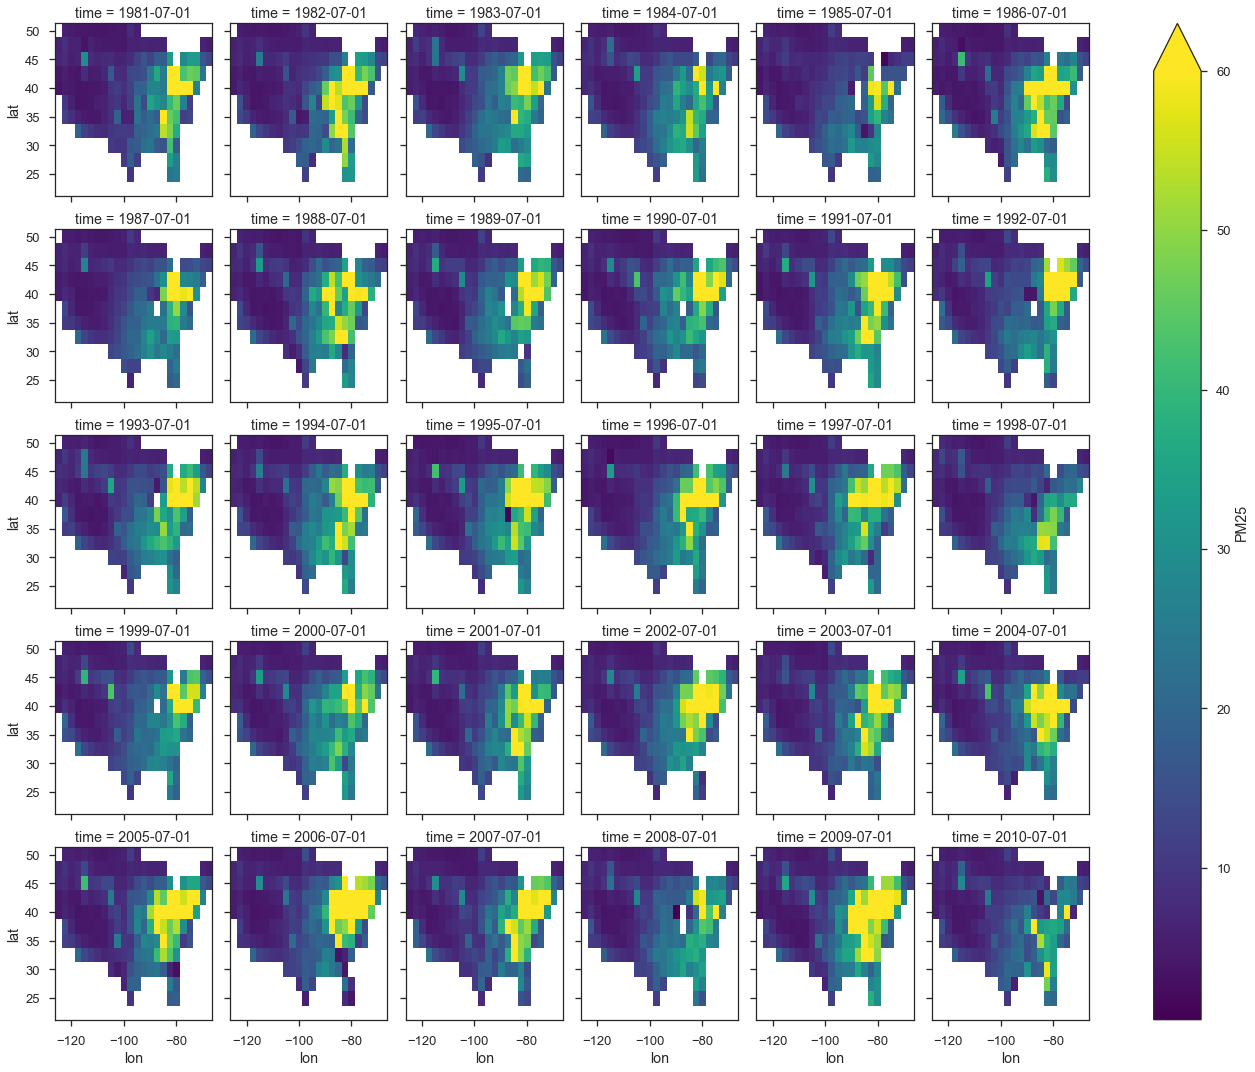

In [138]:
model_predicted_future['PM25'].plot.imshow(col='time',col_wrap=6, vmax=60)

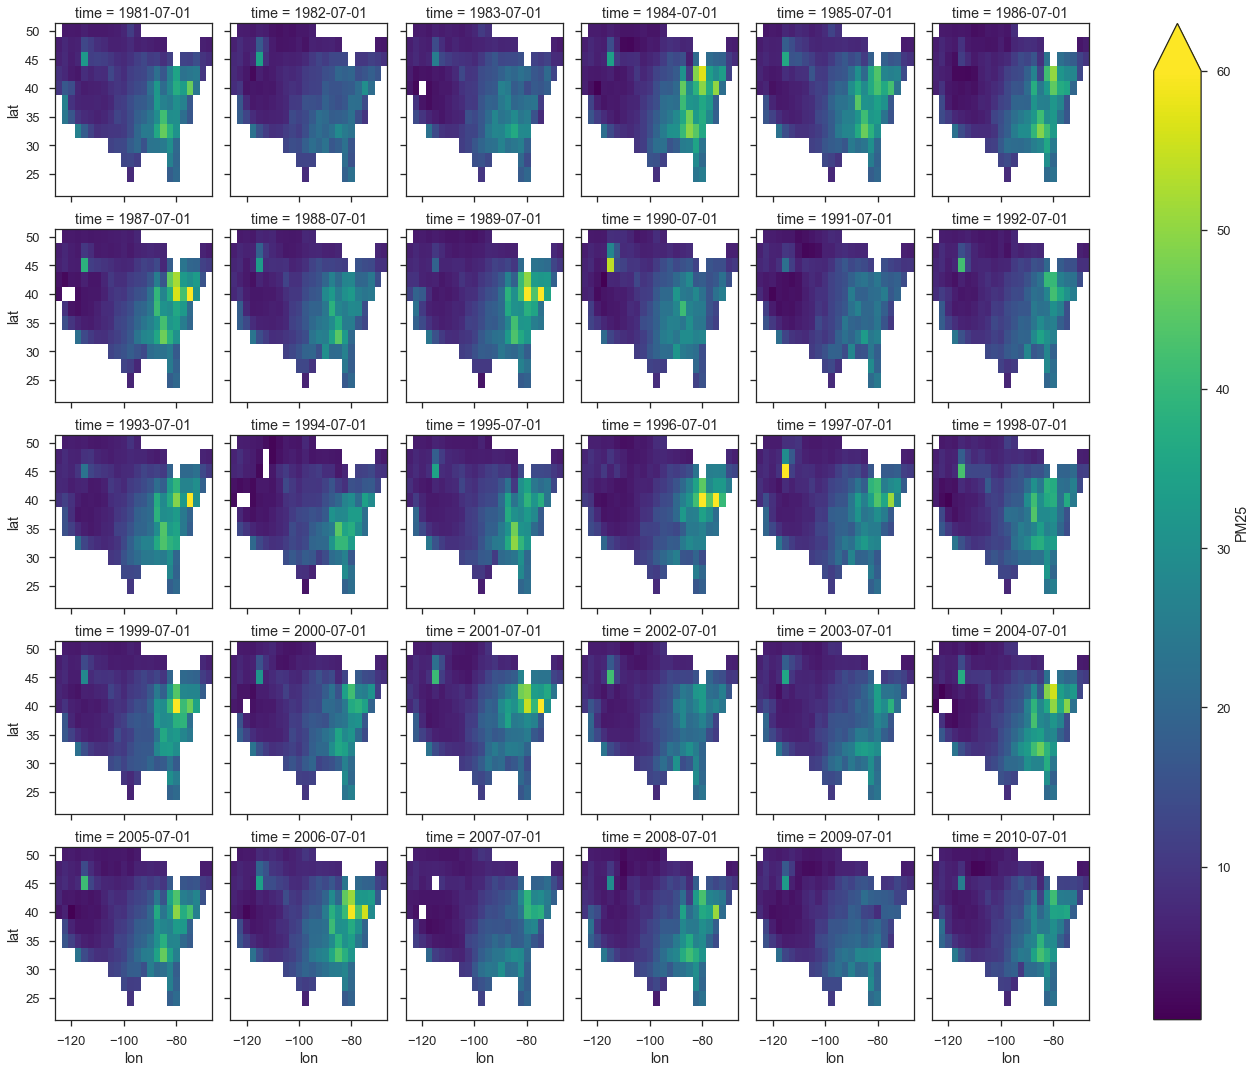

In [139]:
obs_predicted_present['PM25'].plot.imshow(col='time',col_wrap=6, vmax=60)

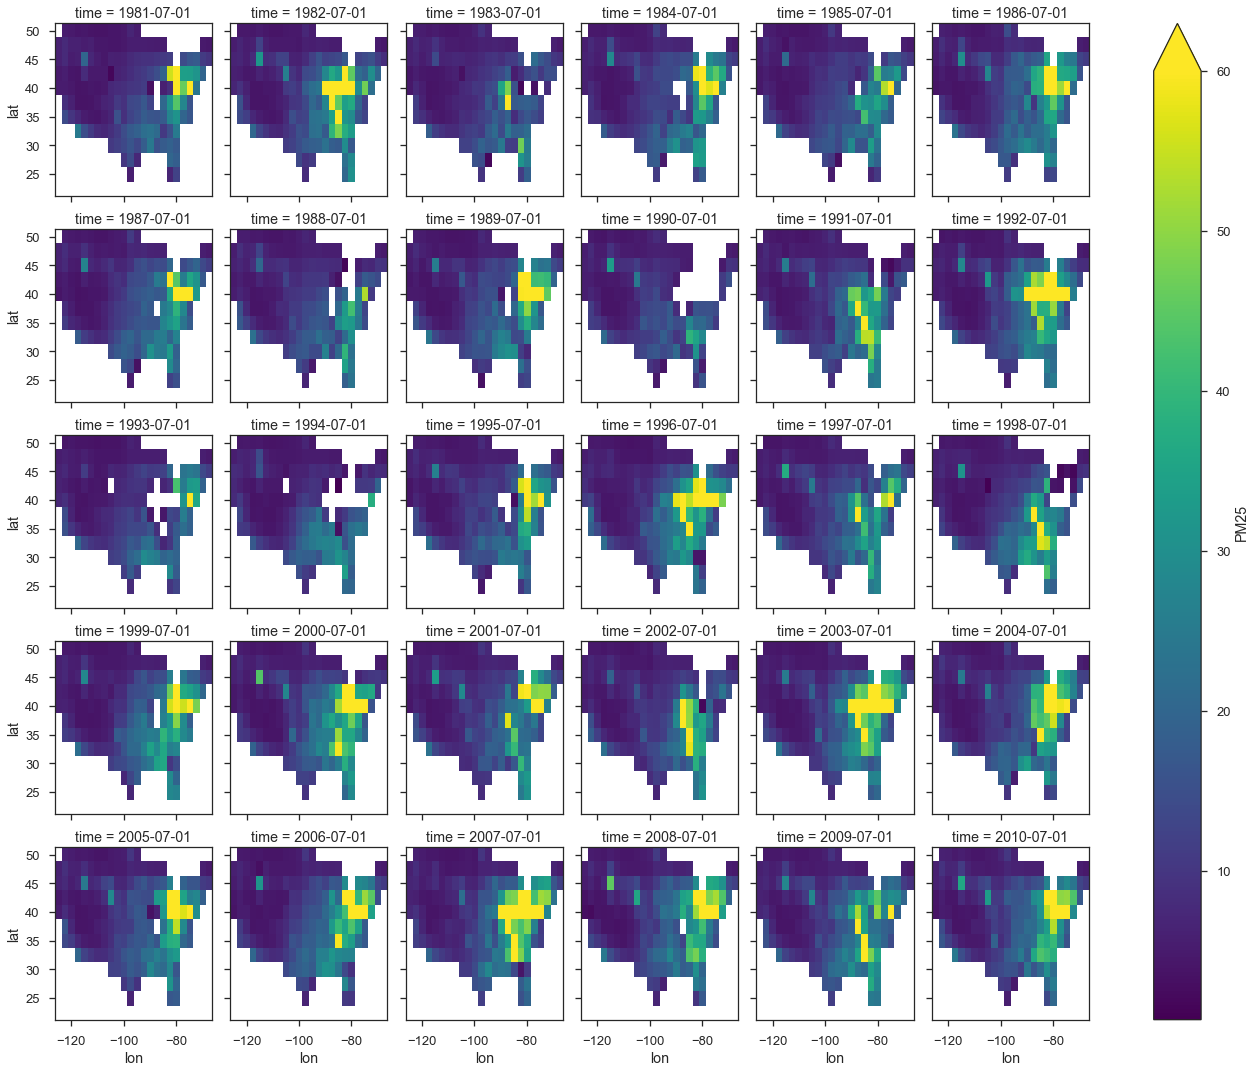

In [140]:
model_predicted_present['PM25'].plot.imshow(col='time',col_wrap=6, vmax=60)

### Mean comparison - future/present PM2.5

How does future and present PM2.5 predicted by each of the trained models look compared to the actual simulated PM2.5 field?

In [19]:
from matplotlib.gridspec import GridSpec

def pct_diff(x, y):
    return 100.*(x - y)/y

def merge_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

def five_panel_comparison(actual, obs_stat, model_stat, tag="", cmap_kws={}):
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(4, 3)

    subplot_kw = dict(projection=STATE_PROJ)

    ax_ul = fig.add_subplot(gs[0:2, 0], **subplot_kw)
    ax_ll = fig.add_subplot(gs[2:, 0], **subplot_kw)
    ax_c = fig.add_subplot(gs[1:3, 1], **subplot_kw)
    ax_ur = fig.add_subplot(gs[0:2, 2], **subplot_kw)
    ax_lr = fig.add_subplot(gs[2:, 2], **subplot_kw)
    axs = [ax_ul, ax_ll, ax_c, ax_ur, ax_lr]


    default_cmap_kws = dict(
        vmin=0, vmax=60, cmap=cmocean.cm.deep,
    )
    default_cmap_kws.update(cmap_kws)

    plot_kws = dict(transform=ccrs.PlateCarree())

    all_kws = merge_dicts(plot_kws, default_cmap_kws)
    obs_stat.plot.imshow(ax=ax_ul, **all_kws)
    ax_ul.set_title("AQS/Statistical \n {}".format(tag))
    actual.plot.imshow(ax=ax_c, **all_kws)
    ax_c.set_title(tag)
    model_stat.plot.imshow(ax=ax_ur, **all_kws)
    ax_ur.set_title("CESM/Statistical \n {}".format(tag))

    diff_cmap_kws = dict(
        vmin=-100, vmax=100, cmap=cmocean.cm.balance
    )
    all_kws = merge_dicts(plot_kws, diff_cmap_kws)
    pct_diff(obs_stat, actual).plot.imshow(ax=ax_ll, **all_kws)
    ax_ll.set_title("Relative Error (%) \n CESM Actual vs Statistical")
    pct_diff(model_stat, actual).plot.imshow(ax=ax_lr, **all_kws)
    ax_lr.set_title("Relative Error (%) \n CESM Actual vs Statistical")

    for ax in axs:
        # ax.set_title("")
        ax = usa_states_ax(ax=ax, facecolor='None')

    plt.tight_layout()

Future PM2.5

/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:352: RuntimeWarning: invalid value encountered in greater
  x_extent) > FRACTIONAL_OFFSET_THRESHOLD
/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:364: RuntimeWarning: invalid value encountered in greater
  y_extent) > FRACTIONAL_OFFSET_THRESHOLD


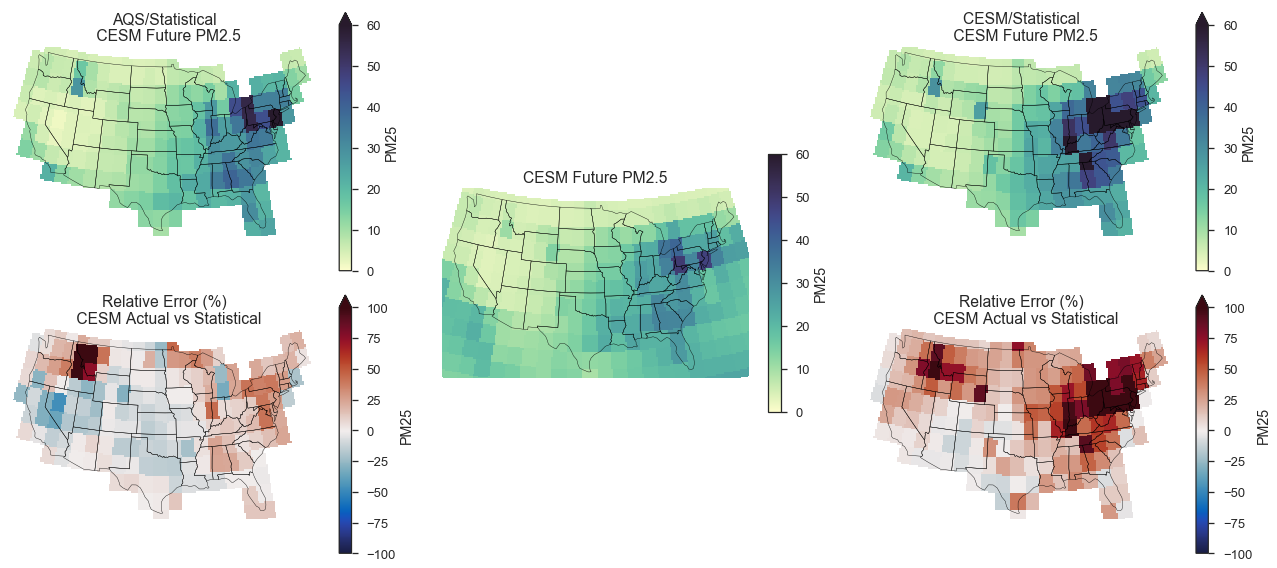

In [23]:
five_panel_comparison(
    _to_model_future['PM25'].mean('time'), 
    obs_predicted_future['PM25'].mean('time'), 
    model_predicted_future['PM25'].mean('time'), 
    cmap_kws={}, tag="CESM Future PM2.5"
)
plt.savefig("../figs/lu_2017/fgm.REF.future_PM2.5-vs-stats.pdf", transparent=True, dpi=300)
plt.savefig("../figs/lu_2017/fgm.REF.future_PM2.5-vs-stats.png", transparent=True, dpi=300)

Present PM2.5

/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:352: RuntimeWarning: invalid value encountered in greater
  x_extent) > FRACTIONAL_OFFSET_THRESHOLD
/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:364: RuntimeWarning: invalid value encountered in greater
  y_extent) > FRACTIONAL_OFFSET_THRESHOLD


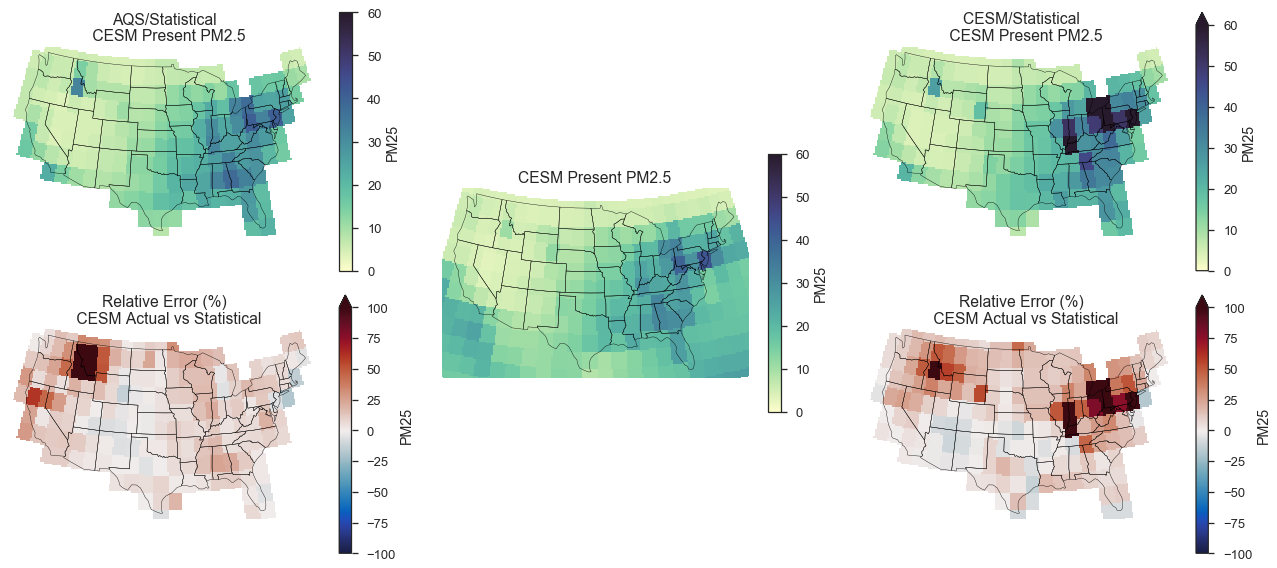

In [21]:
five_panel_comparison(
    _to_model_present['PM25'].mean('time'), 
    obs_predicted_present['PM25'].mean('time'), 
    model_predicted_present['PM25'].mean('time'), 
    cmap_kws={}, tag="CESM Present PM2.5"
)

### Change in PM2.5

Using the statistical model to predict both present and future PM2.5, how does the change in PM2.5 compare to what the dynamic model actually predicts?

In [146]:
actual_change = (_to_model_future  - _to_model_present)['PM25'].mean('time')
actual_change_rel = 100*actual_change / _to_model_present['PM25'].mean('time')

obs_predicted_change = (
    obs_predicted_future - obs_predicted_present
)['PM25'].mean('time')
obs_predicted_change_rel = \
    100*obs_predicted_change / obs_predicted_present['PM25'].mean('time')

model_predicted_change = (
    model_predicted_future - model_predicted_present
)['PM25'].mean('time')
model_predicted_change_rel = \
    100*model_predicted_change / model_predicted_present['PM25'].mean('time')

/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:352: RuntimeWarning: invalid value encountered in greater
  x_extent) > FRACTIONAL_OFFSET_THRESHOLD
/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:364: RuntimeWarning: invalid value encountered in greater
  y_extent) > FRACTIONAL_OFFSET_THRESHOLD


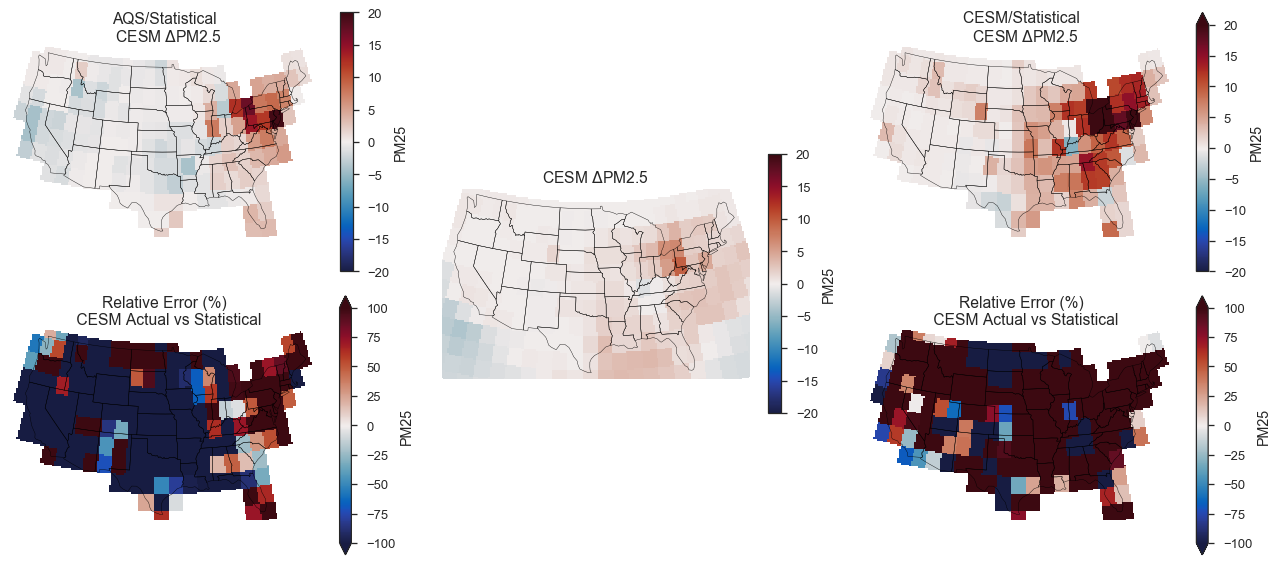

In [155]:
five_panel_comparison(
    actual_change, obs_predicted_change, model_predicted_change, 
    cmap_kws=dict(vmin=-20, vmax=20, cmap=cmocean.cm.balance), 
    tag="CESM $\Delta$PM2.5"
)


---

In [100]:
from air_quality.models.shen2017 import _normalize

_to_model_future = data_future_rs.sel(time=data_future_rs['time.month'] == month).copy()
_to_model_present = data_present_rs.sel(time=data_present_rs['time.month'] == month).copy()

model_predicted_future = model_model.predict(
    model_model.transform(_to_model_future)
)
model_predicted_future = model_model.untransform(model_predicted_future)


model_predicted_pesent = model_model.predict(
    model_model.transform(_to_model_present)
)
model_predicted_present = model_model.untransform(model_predicted_present)


Iterate over grid cell models: 100%|██████████| 288/288 [00:11<00:00, 26.01it/s]


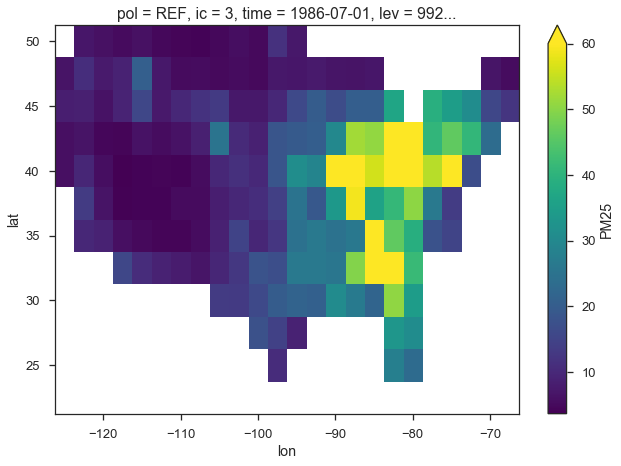

In [108]:
model_predicted_future['PM25'].isel(time=5).plot.imshow(vmax=60)

/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:352: RuntimeWarning: invalid value encountered in greater
  x_extent) > FRACTIONAL_OFFSET_THRESHOLD
/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:364: RuntimeWarning: invalid value encountered in greater
  y_extent) > FRACTIONAL_OFFSET_THRESHOLD


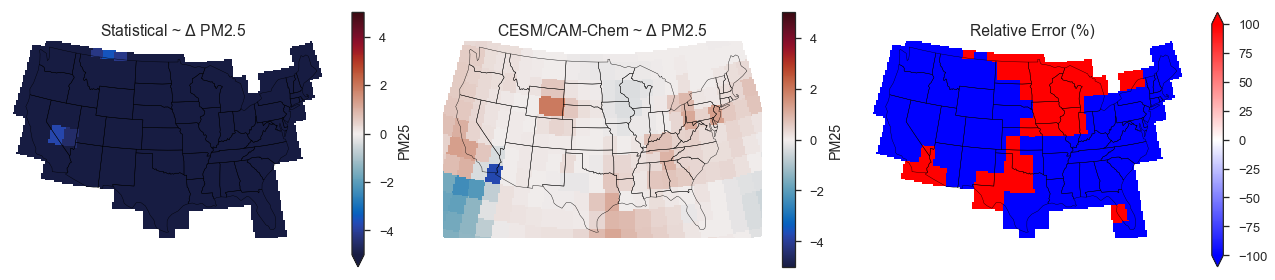

In [101]:
model_delta = (model_predicted_future - model_predicted_present).mean('time')['PM25']
actual_delta = (data_future_rs - data_present_rs).mean('time')['PM25']

fig, axs = plot_predicted_vs_actual(model_delta, actual_delta, geo=True, 
                                    cmap_kws=dict(vmin=-5, vmax=5, cmap=cmocean.cm.balance))
axs[0].set_title("Statistical ~ $\Delta$ PM2.5")
axs[1].set_title("CESM/CAM-Chem ~ $\Delta$ PM2.5")

---

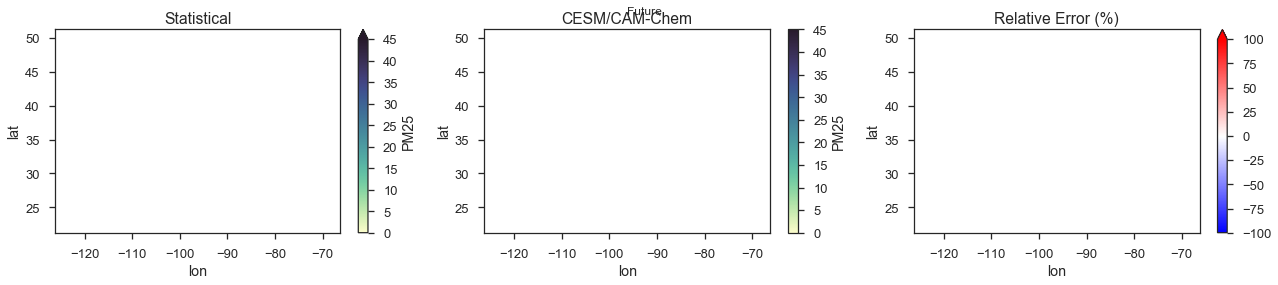

In [69]:
statistical = model_predicted_future['PM25'].mean('time', skipna=True)
actual = _to_model_future['PM25'].mean('time', skipna=True)

fig, axs = plot_predicted_vs_actual(statistical, actual, geo=False, cmap_kws=dict(vmax=45))
axs[0].set_title("Statistical")
axs[1].set_title("CESM/CAM-Chem")
fig.suptitle("Future")

Change in PM2.5 b/t present day and future for both the statistical and the actual modeled data.